In [303]:
suppressWarnings(suppressPackageStartupMessages(library(ggplot2)))
suppressWarnings(suppressPackageStartupMessages(library(RColorBrewer)))
suppressWarnings(suppressPackageStartupMessages(library(scran)))
suppressWarnings(suppressPackageStartupMessages(library(dplyr)))
suppressWarnings(suppressPackageStartupMessages(library(ggbeeswarm)))

In [ ]:
# load dataset

In [10]:
sce = readRDS("/hps/nobackup/hipsci/scratch/singlecell_endodiff/data_processed/merged/20180618/sce_merged_afterqc_filt_allexpts.rds") 

In [310]:
sce = normalize(sce)
design = model.matrix(~ experiment, data = colData(sce))
alt.fit = trendVar(sce, design = design, use.spikes = FALSE)
alt.decomp = decomposeVar(sce, alt.fit)

Warning message in .local(object, ...):
“spike-in transcripts in 'ERCC' should have their own size factors”

In [311]:
# get top 500
top.500.hvgs <- rownames(alt.decomp[order(alt.decomp$bio, decreasing = TRUE),][1:500,])
# get PC1 from expression of the top 500 hvgs
sce_500hvg = sce[rownames(sce) %in% top.500.hvgs,]
p1 = as.data.frame(prcomp(t(logcounts(sce_500hvg)))$x[,1])
colnames(p1) = "PC1_top500hvgs"
head(p1)

,PC1_top500hvgs
21843_1#10,-11.7695261
21843_1#100,5.1315308
21843_1#101,-0.6430211
21843_1#102,-14.5080208
21843_1#103,-5.8029849
21843_1#105,-2.3442226


In [312]:
sce$pc1top500hvgs = p1$PC1_top500hvgs

In [313]:
# define pseudotime as PC1 from top 500 HVGs, scaled between 0 and 1

In [314]:
range01 <- function(x){(x-min(x))/(max(x)-min(x))}
sce$pseudotime  <- range01(sce$pc1top500hvgs)

In [ ]:
# make time point (day of collection) specific scesets

In [15]:
sce_0 = sce[,sce$day == "day0"]
sce_1 = sce[,sce$day == "day1"]
sce_2 = sce[,sce$day == "day2"]
sce_3 = sce[,sce$day == "day3"]

In [ ]:
#######################################
######### Figure 3A, left #############
#######################################

In [ ]:
# to quantify average pseudotime per donot, we first make data frames per day

In [340]:
df_pseudo0 = data.frame(pseudo = sce_0$pseudotime, donor = sce_0$donor_short_id, batch = sce_0$experiment)
df_pseudo1 = data.frame(pseudo = sce_1$pseudotime, donor = sce_1$donor_short_id, batch = sce_1$experiment)
df_pseudo2 = data.frame(pseudo = sce_2$pseudotime, donor = sce_2$donor_short_id, batch = sce_2$experiment)
df_pseudo3 = data.frame(pseudo = sce_3$pseudotime, donor = sce_3$donor_short_id, batch = sce_3$experiment)

In [341]:
# count the number of cells and get average pseudotime value per (donor, day) group 
pseudo0 <- df_pseudo0 %>% group_by(donor) %>% summarize(ncells = n(), avg_pseudo = mean(as.numeric(pseudo)))
pseudo1 <- df_pseudo1 %>% group_by(donor) %>% summarize(ncells = n(), avg_pseudo = mean(as.numeric(pseudo)))
pseudo2 <- df_pseudo2 %>% group_by(donor) %>% summarize(ncells = n(), avg_pseudo = mean(as.numeric(pseudo)))
pseudo3 <- df_pseudo3 %>% group_by(donor) %>% summarize(ncells = n(), avg_pseudo = mean(as.numeric(pseudo)))

In [342]:
# only trust average if done with at least 10 cells
N = 10
pseudo0 = pseudo0[pseudo0$ncells > N,]
pseudo1 = pseudo1[pseudo1$ncells > N,]
pseudo2 = pseudo2[pseudo2$ncells > N,]
pseudo3 = pseudo3[pseudo3$ncells > N,]

In [343]:
# combine
pseudo0_bis = inner_join(pseudo0, pseudo3, by = "donor", suffix = c(".day0",".day3"))
colnames(pseudo0_bis)[c(3,5)] <- c("avg_pseudo","diff_capacity")
pseudo1_bis = inner_join(pseudo1, pseudo3, by = "donor", suffix = c(".day1",".day3"))
colnames(pseudo1_bis)[c(3,5)] <- c("avg_pseudo","diff_capacity")
pseudo2_bis = inner_join(pseudo2, pseudo3, by = "donor", suffix = c(".day2",".day3"))
colnames(pseudo2_bis)[c(3,5)] <- c("avg_pseudo","diff_capacity")
pseudo3$diff_capacity = pseudo3$avg_pseudo
head(pseudo3)

donor,ncells,avg_pseudo,diff_capacity
aowh_2,95,0.8065728,0.8065728
aoxv_3,71,0.8101674,0.8101674
bima_1,31,0.6472056,0.6472056
bokz_5,114,0.6299543,0.6299543
cicb_2,26,0.8159076,0.8159076
ciwj_2,39,0.7368834,0.7368834


In [344]:
pseudo0_bis$day = "day0"
pseudo1_bis$day = "day1"
pseudo2_bis$day = "day2"
pseudo3$day = "day3"
cols = c("donor","day","avg_pseudo","diff_capacity")

In [345]:
head(pseudo0_bis)

donor,ncells.day0,avg_pseudo,ncells.day3,diff_capacity,day
aowh_2,88,0.08048854,95,0.8065728,day0
aoxv_3,68,0.06318019,71,0.8101674,day0
bokz_5,159,0.10781365,114,0.6299543,day0
cicb_2,42,0.12387550,26,0.8159076,day0
ciwj_2,40,0.09646589,39,0.7368834,day0
cuhk_2,41,0.14265172,27,0.7788877,day0


In [346]:
# make dataframe for plotting 
df = rbind(pseudo0_bis[,cols], pseudo1_bis[,cols], pseudo2_bis[,cols], pseudo3[,cols])
nrow(df)
head(df[order(df$diff_capacity),])

[1] 358

donor,day,avg_pseudo,diff_capacity
datg_2,day0,0.12142486,0.539943
datg_2,day1,0.21406101,0.539943
datg_2,day2,0.41358173,0.539943
datg_2,day3,0.53994298,0.539943
pelm_3,day0,0.09648867,0.594162
pelm_3,day2,0.70000486,0.594162


In [347]:
length(unique(df$donor)) # donors with data (at least 10 cells) across all time points

[1] 98

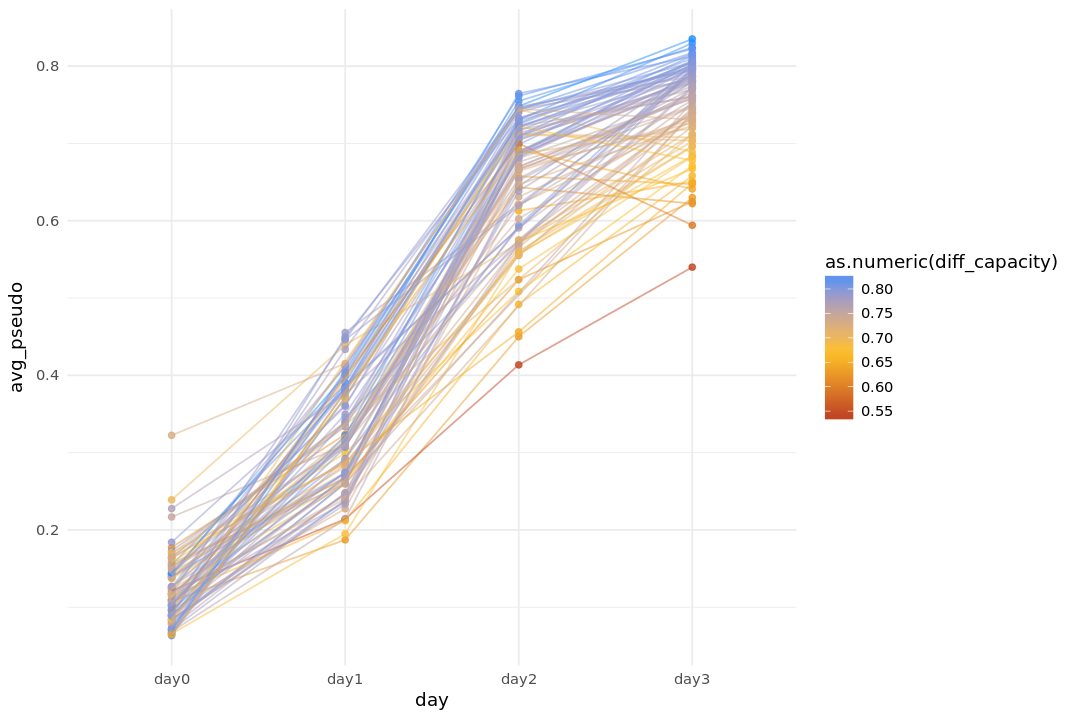

In [421]:
options(repr.plot.width = 9, repr.plot.height = 6)
mid <- min(df$diff_capacity) + 0.45*(max(df$diff_capacity)-min(df$diff_capacity))
ggplot(df, aes(x = day, y = avg_pseudo, col = as.numeric(diff_capacity), group = donor)) + 
#         scale_colour_gradientn(colors = rev(brewer.pal(9,"Spectral"))) +
#         scale_colour_gradientn(colors = brewer.pal("Spectral", n = 9)) +
        scale_colour_gradient2(midpoint = mid, low = "firebrick", mid = "goldenrod1", high = "dodgerblue", space = "Lab") +
#         scale_colour_gradient(low = "red", high = "blue") +
        geom_point(alpha = 0.8) + 
        geom_line(alpha = 0.5) +
        theme_minimal() #+ 
#         theme(panel.background = element_rect(fill = 'grey86'), 
#                                 panel.grid.major = element_line(size = 0.5, linetype = 'solid', colour = "gray90"), 
#                                 panel.grid.minor = element_line(size = 0.5, linetype = 'solid', colour = "gray90"),
#                                panel.border = element_rect(colour = "gray88", fill = NA, size = 0.75))

In [414]:
#######################################
######### Figure 3A, right ############
#######################################

In [415]:
pseudo3_batch <- df_pseudo3 %>% group_by(donor,batch) %>% summarize(ncells = n(), avg_pseudo = mean(as.numeric(pseudo)))

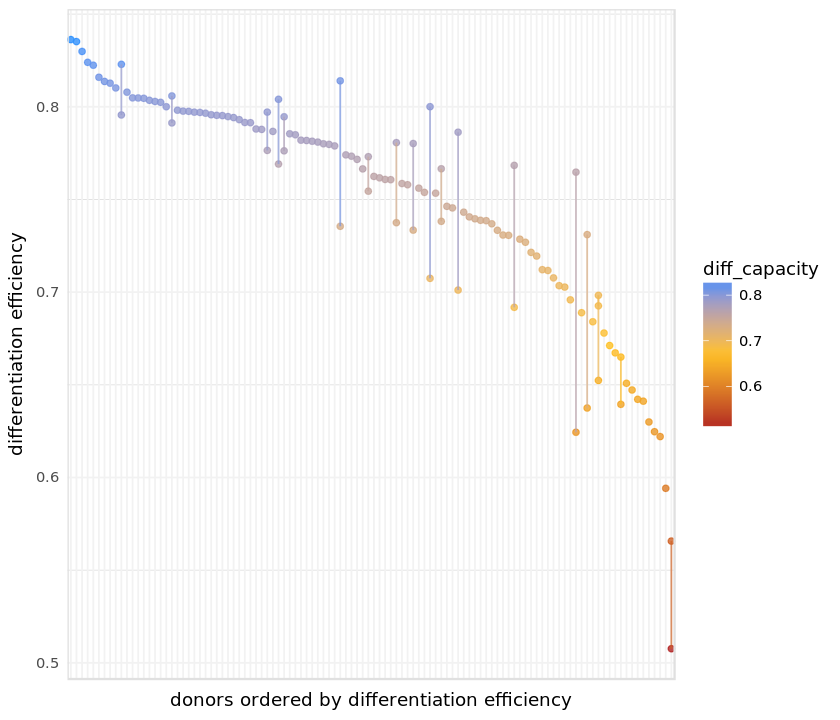

In [420]:
options(repr.plot.width = 7, repr.plot.height = 6)
df3 = pseudo3_batch
df3$diff_capacity = df3$avg_pseudo
ggplot(df3, aes(x = reorder(donor, -diff_capacity), y = diff_capacity, colour = diff_capacity)) + 
#         scale_colour_gradientn(colors = brewer.pal("Spectral", n = 9)) +
        scale_colour_gradient2(midpoint = mid, low = "firebrick", mid = "goldenrod1", high = "dodgerblue", space = "Lab") +
        geom_point(alpha = 0.8) + geom_line(alpha = 0.7) + 
        xlab("donors ordered by differentiation efficiency") + ylab("differentiation efficiency") +
        theme_bw() + theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(),
#                           axis.text.y = element_blank(), 
                              axis.ticks.y = element_blank(), 
                              panel.border = element_rect(colour = "gray88", fill = NA, size = 0.75),
                              panel.grid.major = element_line(size = 0.5, linetype = 'solid', colour = "gray95"), 
                              panel.grid.minor = element_line(size = 0.25, linetype = 'solid',colour = "gray88"))

In [ ]:
########################################
######### Figure 3B, Manhattan #########
########################################

In [182]:
minigwas_filename = "/nfs/leia/research/stegle/dseaton/hipsci/singlecell_endodiff/data/supplementary_tables/SuppTable_S3_differentiation_association_tests_genetic_markers.tsv"
minigwas = read.csv(minigwas_filename, sep = "\t")
head(minigwas)

snp_id,coefficient,pval,snp_chromosome,snp_position,feature,ensembl_gene_id,hgnc_gene_symbol,fdr_bh_adjusted_pval
3_16262617_C_T,-0.04343099,3.920851e-05,3,16262617,ENSG00000154813_DPH3,ENSG00000154813,DPH3,0.1646546
10_71796616_G_A,0.02125921,1.015950e-04,10,71796616,ENSG00000099284_H2AFY2,ENSG00000099284,H2AFY2,0.1646546
10_76829757_A_G,-0.02180539,1.135779e-04,10,76829757,ENSG00000079393_DUSP13,ENSG00000079393,DUSP13,0.1646546
10_122218993_G_A,-0.02430258,1.474739e-04,10,122218993,ENSG00000203805_PPAPDC1A,ENSG00000203805,PPAPDC1A,0.1646546
10_6682022_T_C,-0.02287715,2.120960e-04,10,6682022,ENSG00000065675_PRKCQ,ENSG00000065675,PRKCQ,0.1894442
7_44713844_G_A,-0.03676841,2.834872e-04,7,44713844,ENSG00000158604_TMED4,ENSG00000158604,TMED4,0.2110089


In [194]:
df = minigwas

In [219]:
feature_highlight = "DPH3"

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


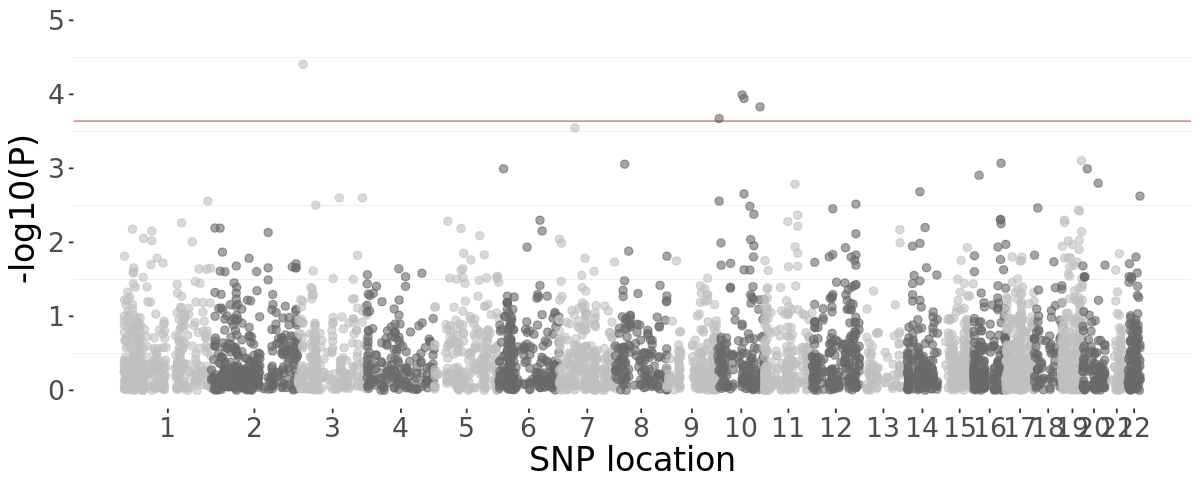

In [222]:
# Prepare the dataset
don <- df %>%   
  # Compute chromosome size
  group_by(snp_chromosome) %>% 
  summarise(chr_len = max(snp_position)) %>% 
  # Calculate cumulative position of each chromosome
  dplyr::mutate(tot = cumsum(chr_len) - chr_len) %>%
  select(-chr_len) %>%  
  # Add this info to the initial dataset
  left_join(df, ., by = c("snp_chromosome" = "snp_chromosome")) %>%  
  # Add a cumulative position of each SNP
  dplyr::arrange(snp_chromosome, snp_position) %>%
  dplyr::mutate( BPcum = snp_position + tot) %>%
  # Add highlight and annotation information
#   dplyr::mutate( is_highlight1 = ifelse(hgnc_gene_symbol %in% feature_highlight, "yes", "no")) %>%
  # Filter SNP to make the plot lighter
  dplyr::filter(-log10(pval) > 0)
  
# Prepare X axis
axisdf <- don %>% group_by(snp_chromosome) %>% summarize(center =( max(BPcum) + min(BPcum) ) / 2 )

# Make the plot
p <- ggplot(don, aes(x = BPcum, y = -log10(pval), text = "")) +
    
    # Show all points
    geom_point( aes(color = as.factor(snp_chromosome)), alpha = 0.6, size = 2) +
    scale_color_manual(values = rep(c("grey75", "dimgrey"), 22 )) +
    
    # custom X axis:
    scale_x_continuous( label = axisdf$snp_chromosome, breaks = axisdf$center ) +
    scale_y_continuous(expand = c(0, 0) ) +     # remove space between plot area and x axis
    ylim(0,-log10(min(don$pval))+0.5)+ 
    xlab("SNP location") +
    ylab("-log10(P)") +

    # Add highlighted points
#     geom_point(data = subset(don, is_highlight1 == "yes"), col = "dodgerblue", size = 1.2, alpha = 0.3) +

    # Add significance threshold
    geom_hline(yintercept = -log10(2.3e-04), alpha = 0.5, col = "firebrick") +
    
    # Custom the theme:
    theme_bw() +
    theme( 
      legend.position="none",
      panel.border = element_blank(),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank(),
      panel.grid.major.y = element_blank(),
      text = element_text(size = 20)
    ) 

options(repr.plot.width = 10, repr.plot.height = 4)
p

In [ ]:
######################################
######### Figure 3B, Boxplot #########
######################################

In [315]:
genos = read.table("/hps/nobackup/hipsci/scratch/genotypes/imputed/2017-03-27/selectionAnna_July3rd.dosages.txt", header = T, row.names = 1)

In [316]:
leads.mesendo = read.csv("/nfs/leia/research/stegle/acuomo/mean/mesendo_est_June20/leads.csv", row.names = 1)
res = leads.mesendo

In [317]:
head(res)

beta,beta_se,empirical_feature_p_value,p_value,snp_id,feature,global_corr_p_value,chrom,pos,ref_allele,⋯,permutation_0,permutation_1,permutation_2,permutation_3,permutation_4,permutation_5,permutation_6,permutation_7,permutation_8,permutation_9
-1.3845452,0.11211982,9.576347e-36,4.944358e-35,19_8387207_G_A,ENSG00000233927_RPS28,7.547212e-32,19,8387207,G,⋯,0.7879920,0.2647253,0.9576956,0.50040265,0.8909294,0.4020912,0.49487435,0.5403312,0.1152362,0.6549657
-1.4456919,0.11350484,1.329834e-33,3.690889e-37,4_39446549_G_A,ENSG00000163682_RPL9,5.240275e-30,4,39446549,G,⋯,0.6314619,0.4871180,0.9815736,0.01588724,0.4807481,0.5794532,0.41743051,0.9794028,0.0231124,0.7822067
-1.1192718,0.10874715,1.381364e-31,7.623224e-25,11_320394_C_T,ENSG00000142089_IFITM3,3.628888e-28,11,320394,C,⋯,0.4461959,0.9987949,0.6529241,0.60878603,0.3638194,0.2279754,0.60792766,0.3837839,0.3409388,0.1409168
1.7971633,0.14662735,3.090601e-29,1.547255e-34,7_55833413_A_C,ENSG00000226278_PSPHP1,6.089332e-26,7,55833413,A,⋯,0.8810951,0.7548001,0.0463951,0.31231023,0.8631418,0.3477155,0.06375912,0.6925864,0.6337930,0.9168980
-1.7892350,0.17296110,1.389047e-26,4.421858e-25,6_29812578_C_A,ENSG00000206503_HLA-A,2.142262e-23,6,29812578,C,⋯,0.4343010,0.2249889,0.6861235,0.59329155,0.1458394,0.8383947,0.83777287,0.6360869,0.7044546,0.4240043
-0.9147762,0.09182129,1.801647e-26,2.222372e-23,7_72717933_C_T,ENSG00000130305_NSUN5,2.142262e-23,7,72717933,C,⋯,0.5910048,0.2025216,0.3184799,0.96892759,0.4173330,0.8469457,0.89982092,0.2036740,0.1484174,0.2666567


In [318]:
i = grep("DPH3",res$feature)
qtl = res[i,]
qtl

,beta,beta_se,empirical_feature_p_value,p_value,snp_id,feature,global_corr_p_value,chrom,pos,ref_allele,⋯,permutation_0,permutation_1,permutation_2,permutation_3,permutation_4,permutation_5,permutation_6,permutation_7,permutation_8,permutation_9
800,0.484232,0.1171636,0.002408729,3.581284e-05,3_16262617_C_T,ENSG00000154813_DPH3,0.02406011,3,16262617,C,⋯,0.03367757,0.2737134,0.02930866,0.8774853,0.2637899,0.5462344,0.7617783,0.05795849,0.5097781,0.5380443


In [325]:
gene = qtl$feature
snp = qtl$snp_id 
snp_name = "rs73138519"
ref = unlist(strsplit(snp,"_"))[3]
alt = unlist(strsplit(snp,"_"))[4]
sce = sce_3
df0 = data.frame(donor = sce$donor_short_id, expt = sce$experiment, day = sce$day, pseudotime = sce$pseudotime)
# sce = sce_mesendo
# df0 = data.frame(donor = sce$donor_short_id, expt = sce$experiment, day = sce$day, exprs = logcounts(sce)[gene,])
df0 <- dplyr::mutate(df0, donor.expt.day = paste0(donor, "-", expt, "-", day))
df1 <- df0 %>% group_by(donor.expt.day) %>% summarize(mean.pseudo = mean(as.numeric(pseudotime)))
# df1 <- df0 %>% group_by(donor.expt.day) %>% summarize(mean.exprs.sc = mean(as.numeric(exprs)))

In [326]:
df1$donor <- gsub("*-.*","",df1$donor.expt.day)
df1$expt <- gsub("*-.*","",gsub(".*-e","e",df1$donor.expt.day))
df1$day <- gsub(".*-","",df1$donor.expt.day)

In [327]:
# select snp
geno = genos[rownames(genos) == snp,]
df2 = as.data.frame(t(rbind(geno,colnames(geno))))
df2[,2] = gsub("\\.","-",df2[,2])
df2[,2] = gsub(".*-","",df2[,2])
colnames(df2) = c("dosages","donor")
df2 <- dplyr::mutate(df2, genotypes = round(as.numeric(dosages)))
head(df2)

dosages,donor,genotypes
2,zihe_1,2
2,eesb_1,2
2,eika_2,2
2,quls_2,2
2,hajc_1,2
2,vuna_3,2


In [328]:
# make dataframe
df = as.data.frame(left_join(df1, df2, by = "donor"))
head(df)

donor.expt.day,mean.pseudo,donor,expt,day,dosages,genotypes
aowh_2-expt_29-day3,0.8140082,aowh_2,expt_29,day3,2,2
aowh_2-expt_30-day3,0.7355234,aowh_2,expt_30,day3,2,2
aoxv_3-expt_43-day3,0.8101674,aoxv_3,expt_43,day3,2,2
bezi_1-expt_39-day3,0.6421778,bezi_1,expt_39,day3,1,1
bima_1-expt_42-day3,0.6472056,bima_1,expt_42,day3,2,2
bokz_5-expt_34-day3,0.6299543,bokz_5,expt_34,day3,1.253,1


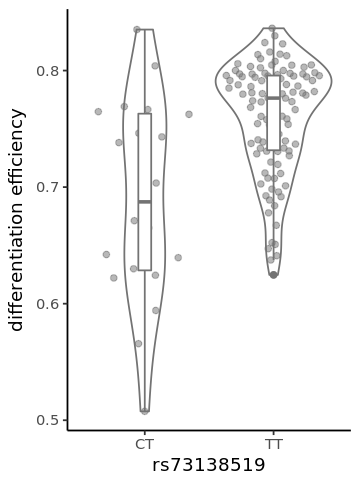

In [337]:
col1 = "grey45"
col2 = "grey45"
df$alleles = c()
df$alleles[df$genotypes == 0] <- paste0(ref,ref)
df$alleles[df$genotypes == 1] <- paste0(ref,alt)
df$alleles[df$genotypes == 2] <- paste0(alt,alt)
options(repr.plot.width = 3, repr.plot.height = 4)
ggplot(df[df$genotypes %in% c(0,1,2),], aes(x = as.factor(alleles), y = as.numeric(mean.pseudo))) + 
        geom_violin(col = col1)+
        geom_quasirandom(aes(x = as.factor(alleles), y = as.numeric(mean.pseudo)), col = col2, alpha = 0.5) +
        geom_boxplot(width = 0.1, col = col2) + xlab(snp_name) +
        labs(y = "differentiation efficiency") + theme_classic()

In [ ]:
########################################
######### Figure 3C, Manhattan #########
########################################

In [259]:
x_chrom_predict_filename = "/nfs/leia/research/stegle/dseaton/hipsci/singlecell_endodiff/data/differentiation_prediction/differentiation_marker_LMM_w_donor_results.transcriptome_wide_scan_pseudotime.tsv"
x_chrom_predict = read.csv(x_chrom_predict_filename, sep = "\t")
head(x_chrom_predict)

timepoint1,gene1,timepoint2,gene2,coefficient,pval
day2,RHOBTB3,day3,pseudotime,0.03021659,1.627948e-12
day2,pseudotime,day3,pseudotime,0.45514869,2.521506e-11
day2,NFKBIA,day3,pseudotime,0.03363206,7.330706e-11
day2,FABP7,day3,pseudotime,-0.07669604,9.433033e-11
day2,MCF2L2,day3,pseudotime,0.04256104,1.681768e-09
day2,NANOG,day3,pseudotime,-0.03843010,2.797062e-09


In [260]:
x_chrom_predict_day0 = x_chrom_predict[x_chrom_predict$timepoint1 == "day0",]
x_chrom_predict_day0$hgnc_symbol = x_chrom_predict_day0$gene1
head(x_chrom_predict_day0)

,timepoint1,gene1,timepoint2,gene2,coefficient,pval,hgnc_symbol
57,day0,GRPR,day3,pseudotime,-0.06123211,8.675658e-07,GRPR
62,day0,ZDHHC9,day3,pseudotime,-0.04286353,1.130310e-06,ZDHHC9
135,day0,GPM6B,day3,pseudotime,-0.03571242,1.170422e-05,GPM6B
139,day0,TMEM47,day3,pseudotime,-0.04089212,1.252561e-05,TMEM47
159,day0,MOSPD2,day3,pseudotime,-0.05051760,1.647873e-05,MOSPD2
176,day0,FAM92A1,day3,pseudotime,-0.03788094,2.079964e-05,FAM92A1


In [261]:
## add gene info
gene_info_filename = "/nfs/leia/research/stegle/dseaton/genomes/hg19/annotation/Homo_sapiens.GRCh37.75.genes.bed"
gene_info = read.table(gene_info_filename)
colnames(gene_info) = c("chromosome_name","start_position","end_position","ensembl_gene_id","gene_biotype","strand")
head(gene_info)

chromosome_name,start_position,end_position,ensembl_gene_id,gene_biotype,strand
1,11868,14412,ENSG00000223972,pseudogene,+
1,14362,29806,ENSG00000227232,pseudogene,-
1,29553,31109,ENSG00000243485,lincRNA,+
1,34553,36081,ENSG00000237613,lincRNA,-
1,52472,54936,ENSG00000268020,pseudogene,+
1,62947,63887,ENSG00000240361,pseudogene,+


In [262]:
gene_annos_filename = "/hps/nobackup/hipsci/scratch/singlecell_endodiff/data_processed/scQTLs/annos/combined_feature_id_annos.tsv"
gene_annos = read.csv(gene_annos_filename, sep = "\t")
head(gene_annos)

feature_id,chromosome,start,end,hgnc_symbol,combined_feature_id,ensembl_gene_id
ENSG00000000003_TSPAN6,X,99883667,99894988,TSPAN6,ENSG00000000003_TSPAN6,ENSG00000000003
ENSG00000000419_DPM1,20,49551404,49575092,DPM1,ENSG00000000419_DPM1,ENSG00000000419
ENSG00000000457_SCYL3,1,169818772,169863408,SCYL3,ENSG00000000457_SCYL3,ENSG00000000457
ENSG00000000460_C1orf112,1,169631245,169823221,C1orf112,ENSG00000000460_C1orf112,ENSG00000000460
ENSG00000001036_FUCA2,6,143815948,143832827,FUCA2,ENSG00000001036_FUCA2,ENSG00000001036
ENSG00000001084_GCLC,6,53362139,53481768,GCLC,ENSG00000001084_GCLC,ENSG00000001084


In [263]:
df.gene = inner_join(gene_info, gene_annos, by = "ensembl_gene_id")
head(df.gene)

chromosome_name,start_position,end_position,ensembl_gene_id,gene_biotype,strand,feature_id,chromosome,start,end,hgnc_symbol,combined_feature_id
1,14362,29806,ENSG00000227232,pseudogene,-,ENSG00000227232_WASH7P,1,14363,29806,WASH7P,ENSG00000227232_WASH7P
1,52472,54936,ENSG00000268020,pseudogene,+,ENSG00000268020_OR4G4P,1,52473,54936,OR4G4P,ENSG00000268020_OR4G4P
1,564441,564813,ENSG00000225972,pseudogene,+,ENSG00000225972_MTND1P23,1,564442,564813,MTND1P23,ENSG00000225972_MTND1P23
1,565019,566063,ENSG00000225630,pseudogene,+,ENSG00000225630_MTND2P28,1,565020,566063,MTND2P28,ENSG00000225630_MTND2P28
1,569075,569756,ENSG00000248527,pseudogene,+,ENSG00000248527_MTATP6P1,1,569076,569756,MTATP6P1,ENSG00000248527_MTATP6P1
1,860259,879955,ENSG00000187634,protein_coding,+,ENSG00000187634_SAMD11,1,860260,879955,SAMD11,ENSG00000187634_SAMD11


In [264]:
nrow(x_chrom_predict_day0)
df = left_join(x_chrom_predict_day0, df.gene, by = "hgnc_symbol")
nrow(df)

[1] 11249

[1] 11249

In [265]:
df = df[!(is.na(df$start_position)),]
nrow(df)

[1] 11149

In [266]:
add_TSS <- function(res){                                       
    res[res$strand == "+","TSS"] = res[res$strand == "+","start_position"]
    res[res$strand == "-","TSS"] = res[res$strand == "-","end_position"]
    res
}

In [267]:
df = add_TSS(df)

In [268]:
df$corr_pval = p.adjust(df$pval, method = "BH")

In [269]:
## features to highlight in the Manhattan plot
# significant, NOT on X chromosome
featuresOfInterestNotX = df[df$corr_pval < 0.1 & df$chromosome_name != "X", "feature_id"]
# significant, ON X chromosome
featuresOfInterestX = df[df$corr_pval < 0.1 & df$chromosome_name == "X", "feature_id"]

In [270]:
example_X = rownames(sce)[grep("ZDHHC9",rownames(sce))]
example_X

[1] "ENSG00000188706_ZDHHC9"

In [273]:
## P value corresponding to largest significant corrected P 
df_sign = df[df$corr_pval < 0.1,]
mythresh = round(-log10(tail(df_sign[order(df_sign$corr_pval),],1)[,"pval"]),digits = 2)
mythresh

[1] 3.51

In [274]:
df = df[df$chromosome_name %in% c(1:22,"X"),]
# re-order chromosome names
df$CHR = as.factor(df$chromosome)
levels(df$CHR)
df$CHR =factor(df$CHR, levels(df$CHR)[c(1,12,16:22,2:11,13:15,23)])
levels(df$CHR)

[1] "1"  "10" "11" "12" "13" "14" "15" "16" "17" "18" "19" "2"  "20" "21" "22"
[16] "3"  "4"  "5"  "6"  "7"  "8"  "9"  "X"

[1] "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "11" "12" "13" "14" "15"
[16] "16" "17" "18" "19" "20" "21" "22" "X"

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


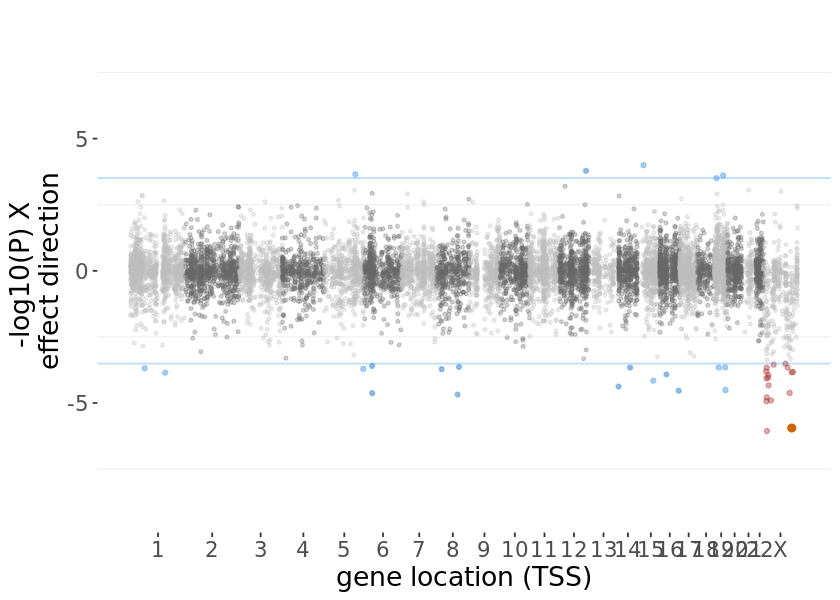

In [283]:
# Prepare the dataset
don <- df %>%   
  # Compute chromosome size
  group_by(CHR) %>% 
  summarise(chr_len = max(TSS)) %>% 
  # Calculate cumulative position of each chromosome
  dplyr::mutate(tot = cumsum(chr_len) - chr_len) %>%
  select(-chr_len) %>%  
  # Add this info to the initial dataset
  left_join(df, ., by = c("CHR" = "CHR")) %>%  
  # Add a cumulative position of each SNP
  dplyr::arrange(CHR, TSS) %>%
  dplyr::mutate( BPcum = TSS + tot) %>%
  # Add highlight and annotation information
  dplyr::mutate( is_highlight1 = ifelse(feature_id %in% featuresOfInterestNotX, "yes", "no")) %>%
  dplyr::mutate( is_highlight2 = ifelse(feature_id %in% featuresOfInterestX, "yes", "no")) %>%
  # specific examples
  dplyr::mutate( is_highlight3 = ifelse(feature_id == example_X, "yes", "no")) %>%
  # Filter SNP to make the plot lighter
  dplyr::filter(-log10(pval) > 0)
  
# Prepare X axis
axisdf <- don %>% group_by(CHR) %>% summarize(center =( max(BPcum) + min(BPcum) ) / 2 )

# Make the plot
p <- ggplot(don, aes(x = BPcum, y = -log10(pval)*sign(coefficient), text = "")) +
    
    # Show all points
    geom_point( aes(color = as.factor(CHR)), alpha = 0.3, size = 0.8) +
    scale_color_manual(values = rep(c("grey75", "dimgrey"), 22 )) +
    
    # custom X axis:
    scale_x_continuous( label = axisdf$CHR, breaks = axisdf$center ) +
    scale_y_continuous(expand = c(0, 0) ) +     # remove space between plot area and x axis
    ylim(-9,9)+ 
    xlab("gene location (TSS)") +
    ylab("-log10(P) X \neffect direction") +

    # Add highlighted points
    geom_point(data = subset(don, is_highlight1 == "yes"), col = "dodgerblue", size = 1.2, alpha = 0.3) +
    geom_point(data = subset(don, is_highlight2 == "yes"), col = "firebrick", size = 1.2, alpha = 0.3) +
    geom_point(data = subset(don, is_highlight3 == "yes"), col = "darkorange3", size = 1.9) +
#     geom_point(data = subset(don, is_highlight4 == "yes"), col = "#344d90", size = 1.8) +
 
#     geom_point(data = subset(don, is_highlight3 == "yes"), col = "green", size = 3) +
    
    # Add significance threshold
    geom_hline(yintercept = mythresh, alpha = 0.3, col = "dodgerblue") +
    geom_hline(yintercept = -mythresh, alpha = 0.3, col = "dodgerblue") +
    
    # Custom the theme:
    theme_bw() +
    theme( 
      legend.position="none",
      panel.border = element_blank(),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank(),
      panel.grid.major.y = element_blank(),
      text = element_text(size = 16)
    ) 


options(repr.plot.width = 7, repr.plot.height = 5)
p

In [ ]:
##########################################
######### Figure 3C, Scatterplot #########
##########################################

In [184]:
ZDHHC9_filename = "/nfs/leia/research/stegle/dseaton/hipsci/singlecell_endodiff/data/differentiation_prediction/differentiation_marker_LMM_w_donor_results_subset_of_day0_markers_data/day0_ZDHHC9_day3_pseudotime.tsv"
ZDHHC9 = read.csv(ZDHHC9_filename, sep = "\t")
head(ZDHHC9)

experiment,donor,phenotype,fixed_effect,residual
expt_22,eoxi,0.8028691,5.407826,0.016888133
expt_22,fawm,0.7074314,5.376837,-0.002927534
expt_22,iudw,0.6711877,6.052343,-0.010452791
expt_22,oebj,0.6917951,6.125818,-0.006174083
expt_22,oojs,0.7616687,6.019017,0.008333726
expt_22,pulk,0.6649738,5.565003,-0.008964453


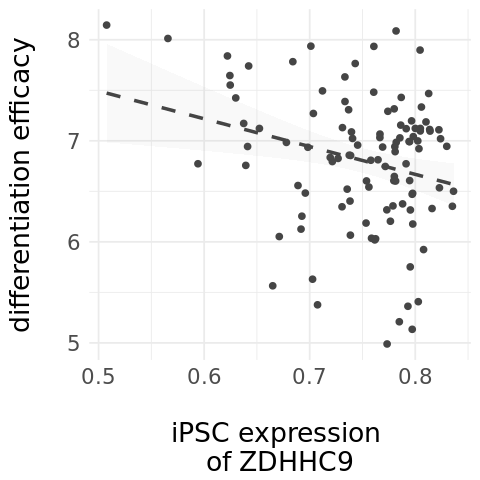

In [338]:
options(repr.plot.width = 4, repr.plot.height = 4)
col = "gray27"
p = ggplot(ZDHHC9, aes(x = phenotype, y = fixed_effect)) + geom_point(col = col)
p = p + stat_smooth(colour = col, linetype = 2, method = "lm", alpha = 0.05)
p = p + theme_minimal() 
p = p + xlab(paste0("\niPSC expression \nof ZDHHC9")) + ylab("differentiation efficacy\n")
p + theme(plot.title = element_text(hjust = 0.5, colour = col),
               text = element_text(size = 16))